In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

pd.options.display.max_columns = 500

### Загрузим датасет с машинами. Цель - верно восстанавливать для каждой из них цену продажи!

In [2]:
data = pd.read_csv(os.path.dirname(os.path.dirname(os.getcwd())) + '/' + 'autos.csv')

data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


In [3]:
### Колонка с тергетом - "selling price"

X = data.drop("selling_price", axis=1)
y = data["selling_price"]

### Будем замерять MSLE!
### Поэтому прологарифмируем таргет
### А после оптимизируем MSE

y = y.apply(np.log1p)

In [4]:
### Разделим выборку на трейн и тест!

from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

__Задание__ 

Реализуйте свой MeanTargetEncoder с добавленем некоторого шума!

Однажды в лекционном материале, обсуждая счетчики, мы говорили с вами о том, что из-за них модели могут переобучаться. Один из способов бороться с этим - валидировать расчеты среднего таргета (стратегия отложенной выборки / расчеты на кросс-валидации). Но есть еще проще!

Можно просто к значению счетчика добавить случайный шум (зашумить данные)!

Напомним, что рассчитываться новые признаки должны по такой формуле:

$$
g_j = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}{l} + C * \epsilon
$$


Пусть шум будет случайной величиной из нормального стандартного распределения, то есть $\epsilon \sim N(0, 1) $, а $ C = 0.006$.

Создавай свой класс-трансформер, наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`. Трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. 
Ваш трансформер должен принимать при инициализации список из категориальных признаков и список из числовых признаков. 

Если для какого-то признака в тестовой выборке отсутствует значение, трансформер должен поставить там 0.

На выходе должен получиться датасет того же размера с измененными категориальными признаками

In [5]:
object_cols = ['name', 'year', 'fuel', 'seller_type', 'transmission', 'owner']
num_cols = ['km_driven']

X.head()

,name,year,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,141000,Diesel,Individual,Manual,Second Owner


In [6]:
from sklearn.base import BaseEstimator, TransformerMixin

class MeanTargetEncoderNoise(BaseEstimator, TransformerMixin):
    
    def __init__(self, categorical, numeric):
        
        ### Your code is here
        self.categorical = categorical
        self.numeric = numeric
    
    def fit(self, X, y):

        Xy = pd.concat((X, y), axis=1).copy()

        ### Your code is here
        self.dict_means = {}
        
        for col in self.categorical:
            means_col = Xy.groupby(col)['selling_price'].mean().apply(lambda x: x + (0.006 * np.random.normal()))
            self.dict_means[col] = means_col

        return self
        
    def transform(self, df):
        
        ### Your code is here
        temp = df.copy()
        
        for col in self.categorical:
            temp[col] = temp[col].map(self.dict_means[col])
            temp[col] = temp[col].fillna(0)
                
        
        return temp

In [7]:
### Проверка работы трансформера

np.random.seed(1)
transformer = MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)

transformer.fit(X_train, y_train)

train = transformer.transform(X_train)
test = transformer.transform(X_test)

train.head()

,name,year,km_driven,fuel,seller_type,transmission,owner
3294,13.483692,13.436559,50000,13.093756,12.615863,13.771135,12.977730
2290,12.117029,11.903115,70000,12.453832,12.615863,13.771135,12.977730
874,12.310456,13.328864,50000,12.453832,12.615863,12.639805,12.977730
1907,12.491443,13.042359,92198,12.453832,13.152824,12.639805,12.463313
3244,12.390906,12.870886,3240,12.453832,12.615863,12.639805,12.463313


Обучите несколько деревьев, перебирая максимальную глубину алгоритма из списка `max_depth_list`, а остальные параметры оставьте дефолтными. Выведите лучшее значение гиперпараметра. Постройте график зависимости MSLE на тестовой выборке от значения гиперпараметра. Воспользуйтесь `Pipeline` без `GridSearch`. Проделайте то же самое с `min_samples_split`, `min_impurity_decrease`, `max_leaf_nodes`. (по 2б на каждый параметр)

In [8]:
max_depth_list = [3, 5, 8, 12]
min_samples_split_list = [10, 50, 100, 500]
min_impurity_decrease_list = [0, 0.1, 0.15, 0.2]
max_leaf_nodes_list = [100, 200, 500]

In [9]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline

np.random.seed(1)
mse_dict = {}

### Your code is here
for depth in max_depth_list:
    pipe = Pipeline([('transformer', MeanTargetEncoderNoise(object_cols, num_cols)),
                     ('decision_tree', DecisionTreeRegressor(max_depth=depth))])
    pipe.fit(X_train, y_train)
    mse_dict.setdefault('depth', []).append((depth, mse(y_test, pipe.predict(X_test))))
    
for samples in min_samples_split_list:
    pipe = Pipeline([('transformer', MeanTargetEncoderNoise(object_cols, num_cols)),
                     ('decision_tree', DecisionTreeRegressor(min_samples_split=samples))])
    pipe.fit(X_train, y_train)
    mse_dict.setdefault('min_samples_split', []).append((samples, mse(y_test, pipe.predict(X_test))))
    
for impurity_decrease in min_impurity_decrease_list:
    pipe = Pipeline([('transformer', MeanTargetEncoderNoise(object_cols, num_cols)),
                     ('decision_tree', DecisionTreeRegressor(min_impurity_decrease=impurity_decrease))])
    pipe.fit(X_train, y_train)
    mse_dict.setdefault('min_impurity_decrease', []).append((impurity_decrease, mse(y_test, pipe.predict(X_test))))
    
for leaf_nodes in max_leaf_nodes_list:
    pipe = Pipeline([('transformer', MeanTargetEncoderNoise(object_cols, num_cols)),
                     ('decision_tree', DecisionTreeRegressor(max_leaf_nodes=leaf_nodes))])
    pipe.fit(X_train, y_train)
    mse_dict.setdefault('max_leaf_nodes', []).append((leaf_nodes, mse(y_test, pipe.predict(X_test))))

In [10]:
tuple(zip(*mse_dict['depth']))

((3, 5, 8, 12),
 (0.7978271003064057,
  1.4407231108105145,
  1.9875843849579033,
  1.9837636765613815))

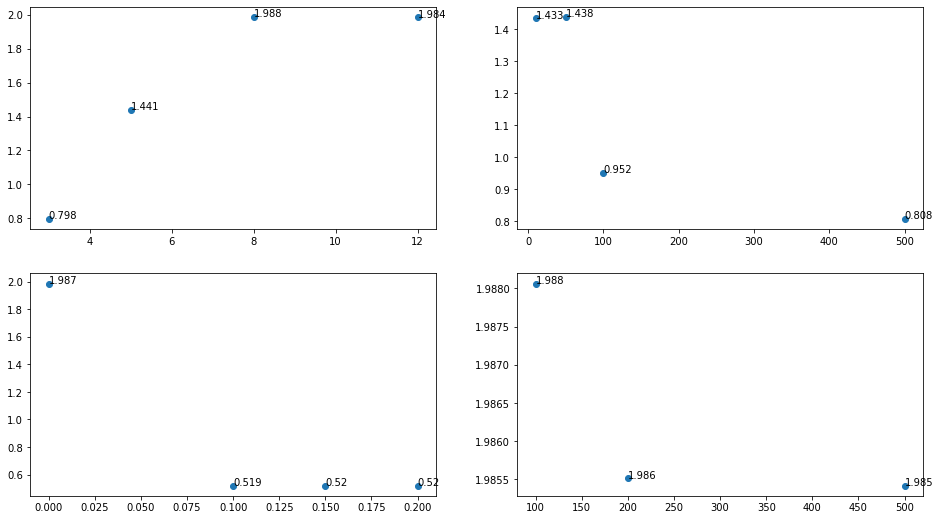

In [11]:
fig = plt.figure(figsize=(16, 9))

for i, key in enumerate(mse_dict.keys()):
    plt.subplot(2, 2, i + 1)
    x, y = tuple(zip(*mse_dict[key]))
    plt.scatter(x, y)
    for i in range(len(x)):
        plt.annotate(str(round(y[i], 3)), xy=(x[i], y[i]))

Подберите лучшую комбинацию параметров, используя `GridSearchCV` и набор массивов значений параметров из предыдущего задания. Для лучшей комбинации посчитайте MSLE на тестовой выборке. Получились ли лучшие параметры такими же, как если бы вы подбирали их по-отдельности при остальных гиперпараметрах по умолчанию (предыдущее задание)? (2б)

In [15]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "decision_tree__max_depth": [3, 5, 8, 12],
    "decision_tree__min_samples_split": [10, 50, 100, 500],
    "decision_tree__min_impurity_decrease": [0, 0.1, 0.15, 0.2],
    "decision_tree__max_leaf_nodes": [100, 200, 500]
}
np.random.seed(1)

### Your code is here

  
pipe = Pipeline([('transformer', MeanTargetEncoderNoise(object_cols, num_cols)),
                     ('decision_tree', DecisionTreeRegressor(max_depth=depth))])

search = GridSearchCV(pipe, param_grid, scoring='neg_mean_squared_error')
search.fit(X_train, y_train)
mse(y_test, search.predict(X_test))

0.5200098587235228

In [16]:
search.best_params_

{'decision_tree__max_depth': 12,
 'decision_tree__max_leaf_nodes': 200,
 'decision_tree__min_impurity_decrease': 0.1,
 'decision_tree__min_samples_split': 100}